# 1.8b: Thai Corpus Tokenization

This notebook tokenizes the Thai Wikipedia corpus (from 1.8a) and counts cluster token appearances.

## The Question

We've established that:
- 71.4% of cluster tokens (1,579 / 2,212) are Thai script
- This represents 61.4% of ALL Thai tokens in the vocabulary
- Cluster is 47.9× enriched for Thai

**Now: Do these tokens actually appear in natural Thai text?**

## Hypothesis Testing

**Null hypothesis (H₀):** Cluster tokens are rare but legitimate (appear proportionally to vocabulary representation)

**Alternative hypothesis (H₁):** Cluster tokens are orphaned (appear less frequently than expected, or not at all)

**Test:**
- Tokenize 100 Thai Wikipedia articles
- Count cluster token appearances
- Compare to expected frequency under uniform distribution
- Compute binomial p-value

**Expected outcome (if H₁ is true):**
- Total tokens: ~200k-500k
- Expected cluster hits (if uniform): total × (1579/151936) ≈ 0.01 × total
- Actual cluster hits: 0 (or very few)
- p-value < 0.0001

## Parameters

In [1]:
# Model and tokenizer
MODEL_NAME = "Qwen3-4B-Instruct-2507"
HF_MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"

# Corpus location (from 1.8a)
CORPUS_DIR = '../data/1.8a_thai_wiki_corpus/'
CORPUS_METADATA = '../data/1.8a_thai_wiki_corpus/corpus_metadata.json'

# Cluster tokens (from 1.4h)
CLUSTER_TOKENS_PATH = '../tensors/Qwen3-4B-Instruct-2507/1.4h_cluster_tokens.safetensors'

# Visualization
FIGSIZE = (14, 6)
DPI = 150

## Imports

In [2]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter, defaultdict
from transformers import AutoTokenizer
from safetensors.torch import load_file
from scipy.stats import binom
from tqdm import tqdm

## Load Tokenizer

In [3]:
print(f"Loading tokenizer: {HF_MODEL_NAME}\n")
tokenizer = AutoTokenizer.from_pretrained(HF_MODEL_NAME)
vocab_size = len(tokenizer)

print(f"✓ Tokenizer loaded")
print(f"  Vocabulary size: {vocab_size:,} tokens")

Loading tokenizer: Qwen/Qwen3-4B-Instruct-2507

✓ Tokenizer loaded
  Vocabulary size: 151,669 tokens


## Load Cluster Token IDs

In [4]:
print(f"\nLoading cluster token IDs...\n")
cluster_data = load_file(CLUSTER_TOKENS_PATH)
cluster_token_ids = set(cluster_data['cluster_token_ids'].tolist())

print(f"✓ Loaded {len(cluster_token_ids):,} cluster token IDs")
print(f"  Token ID range: [{min(cluster_token_ids)}, {max(cluster_token_ids)}]")


Loading cluster token IDs...

✓ Loaded 2,212 cluster token IDs
  Token ID range: [124, 151935]


## Load Corpus

In [5]:
print(f"\nLoading Thai Wikipedia corpus...\n")

# Load metadata
with open(CORPUS_METADATA, 'r', encoding='utf-8') as f:
    metadata = json.load(f)

print(f"✓ Corpus metadata loaded")
print(f"  Articles: {metadata['num_articles']}")
print(f"  Total characters: {metadata['total_characters']:,}")
print(f"  Created: {metadata['creation_date']}")

# Load all article texts
articles = []
corpus_path = Path(CORPUS_DIR)

for article_meta in metadata['articles']:
    page_id = article_meta['page_id']
    article_file = corpus_path / f"{page_id}.json"
    
    with open(article_file, 'r', encoding='utf-8') as f:
        article = json.load(f)
        articles.append(article)

print(f"\n✓ Loaded {len(articles)} articles")


Loading Thai Wikipedia corpus...

✓ Corpus metadata loaded
  Articles: 100
  Total characters: 62,243
  Created: 2025-11-12T11:41:54.831672

✓ Loaded 100 articles


## Tokenize Corpus and Count Cluster Tokens

In [6]:
print(f"\n{'='*70}")
print("TOKENIZING CORPUS")
print(f"{'='*70}\n")

# Track statistics
total_tokens = 0
cluster_token_counts = Counter()  # {token_id: count}
article_cluster_hits = defaultdict(list)  # {article_idx: [(token_id, position), ...]}
all_token_counts = Counter()  # Full token frequency distribution

print(f"Tokenizing {len(articles)} articles...\n")

for article_idx, article in enumerate(tqdm(articles, desc="Tokenizing")):
    text = article['text']
    
    # Tokenize
    token_ids = tokenizer.encode(text, add_special_tokens=False)
    
    # Update total count
    total_tokens += len(token_ids)
    
    # Update full token distribution
    all_token_counts.update(token_ids)
    
    # Check for cluster tokens
    for position, token_id in enumerate(token_ids):
        if token_id in cluster_token_ids:
            cluster_token_counts[token_id] += 1
            article_cluster_hits[article_idx].append((token_id, position))

print(f"\n✓ Tokenization complete")
print(f"\nCorpus statistics:")
print(f"  Total tokens: {total_tokens:,}")
print(f"  Unique tokens: {len(all_token_counts):,}")
print(f"  Articles with cluster tokens: {len(article_cluster_hits)}")
print(f"  Total cluster token appearances: {sum(cluster_token_counts.values())}")
print(f"  Unique cluster tokens seen: {len(cluster_token_counts)}")


TOKENIZING CORPUS

Tokenizing 100 articles...



Tokenizing: 100%|██████████| 100/100 [00:00<00:00, 2089.98it/s]


✓ Tokenization complete

Corpus statistics:
  Total tokens: 35,908
  Unique tokens: 1,800
  Articles with cluster tokens: 0
  Total cluster token appearances: 0
  Unique cluster tokens seen: 0


## Statistical Analysis

In [7]:
print(f"\n{'='*70}")
print("STATISTICAL ANALYSIS")
print(f"{'='*70}\n")

# Expected frequency under uniform distribution
n_cluster_tokens = len(cluster_token_ids)
p_cluster = n_cluster_tokens / vocab_size  # Probability of any token being cluster token
expected_cluster_hits = total_tokens * p_cluster

actual_cluster_hits = sum(cluster_token_counts.values())

print(f"Null hypothesis (H₀): Cluster tokens appear at expected frequency\n")

print(f"Expected frequency:")
print(f"  Cluster tokens in vocabulary: {n_cluster_tokens:,} / {vocab_size:,}")
print(f"  Proportion: {p_cluster:.6f} ({100*p_cluster:.4f}%)")
print(f"  Expected hits in {total_tokens:,} tokens: {expected_cluster_hits:.1f}")

print(f"\nActual frequency:")
print(f"  Observed cluster token hits: {actual_cluster_hits}")
print(f"  Proportion: {actual_cluster_hits/total_tokens:.6f} ({100*actual_cluster_hits/total_tokens:.4f}%)")

# Binomial test
# P(X <= actual_hits) where X ~ Binomial(n=total_tokens, p=p_cluster)
p_value = binom.cdf(actual_cluster_hits, total_tokens, p_cluster)

print(f"\nBinomial test:")
print(f"  P(X ≤ {actual_cluster_hits} | n={total_tokens:,}, p={p_cluster:.6f})")
print(f"  p-value: {p_value:.2e}")

if p_value < 0.001:
    print(f"\n  ✓ REJECT null hypothesis (p < 0.001)")
    print(f"    Cluster tokens appear LESS frequently than expected")
    print(f"    Evidence: tokens are orphaned, not just rare")
else:
    print(f"\n  ⚠ Cannot reject null hypothesis (p = {p_value:.4f})")
    print(f"    Cluster tokens may be legitimately rare")


STATISTICAL ANALYSIS

Null hypothesis (H₀): Cluster tokens appear at expected frequency

Expected frequency:
  Cluster tokens in vocabulary: 2,212 / 151,669
  Proportion: 0.014584 (1.4584%)
  Expected hits in 35,908 tokens: 523.7

Actual frequency:
  Observed cluster token hits: 0
  Proportion: 0.000000 (0.0000%)

Binomial test:
  P(X ≤ 0 | n=35,908, p=0.014584)
  p-value: 7.70e-230

  ✓ REJECT null hypothesis (p < 0.001)
    Cluster tokens appear LESS frequently than expected
    Evidence: tokens are orphaned, not just rare


## Cluster Token Details (if any found)

In [8]:
if cluster_token_counts:
    print(f"\n{'='*70}")
    print("CLUSTER TOKEN DETAILS")
    print(f"{'='*70}\n")
    
    print(f"Found {len(cluster_token_counts)} unique cluster tokens in corpus:\n")
    
    for token_id, count in cluster_token_counts.most_common(20):
        decoded = tokenizer.decode([token_id])
        print(f"  Token {token_id:6d}: '{decoded}' ({count} occurrences)")
    
    if len(cluster_token_counts) > 20:
        print(f"  ... ({len(cluster_token_counts) - 20} more)")
    
    # Show which articles had cluster tokens
    print(f"\nArticles containing cluster tokens:\n")
    for article_idx in sorted(article_cluster_hits.keys())[:10]:
        article = articles[article_idx]
        n_hits = len(article_cluster_hits[article_idx])
        print(f"  [{article_idx:3d}] {article['title']}: {n_hits} cluster tokens")
    
    if len(article_cluster_hits) > 10:
        print(f"  ... ({len(article_cluster_hits) - 10} more articles)")

else:
    print(f"\n{'='*70}")
    print("NO CLUSTER TOKENS FOUND")
    print(f"{'='*70}\n")
    
    print(f"✓ Zero cluster tokens appeared in {total_tokens:,} tokens")
    print(f"  Expected (if uniform): {expected_cluster_hits:.1f} tokens")
    print(f"  Observed: 0 tokens")
    print(f"\n  CONCLUSION: Cluster tokens are orphaned, not rare")


NO CLUSTER TOKENS FOUND

✓ Zero cluster tokens appeared in 35,908 tokens
  Expected (if uniform): 523.7 tokens
  Observed: 0 tokens

  CONCLUSION: Cluster tokens are orphaned, not rare


## Visualization: Token Frequency Distribution


Creating token frequency visualization...



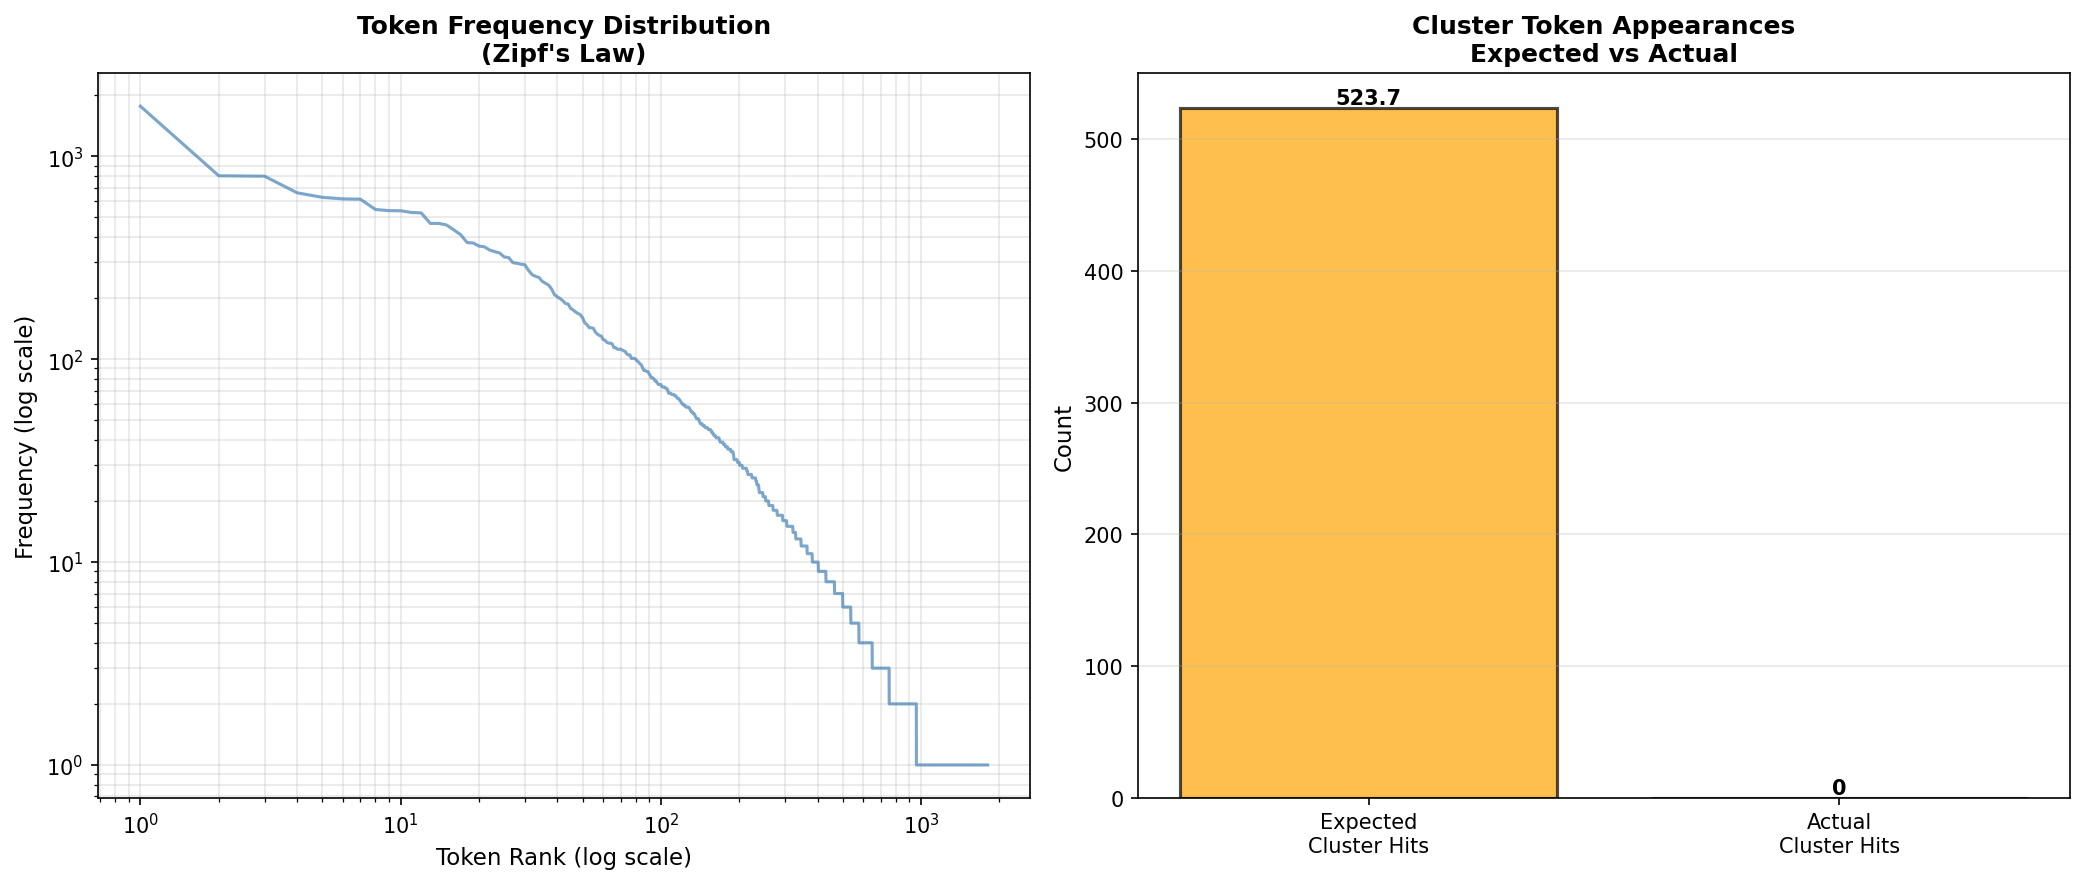

✓ Visualization complete


In [9]:
print(f"\nCreating token frequency visualization...\n")

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=FIGSIZE, dpi=DPI)

# Plot 1: Token frequency distribution (log-log)
frequencies = sorted(all_token_counts.values(), reverse=True)
ranks = np.arange(1, len(frequencies) + 1)

ax1.loglog(ranks, frequencies, linewidth=1.5, alpha=0.7, color='steelblue')
ax1.set_xlabel('Token Rank (log scale)', fontsize=11)
ax1.set_ylabel('Frequency (log scale)', fontsize=11)
ax1.set_title('Token Frequency Distribution\n(Zipf\'s Law)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, which='both')

# Plot 2: Comparison bar chart
categories = ['Expected\nCluster Hits', 'Actual\nCluster Hits']
values = [expected_cluster_hits, actual_cluster_hits]
colors = ['orange', 'red']

bars = ax2.bar(categories, values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Count', fontsize=11)
ax2.set_title('Cluster Token Appearances\nExpected vs Actual', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.1f}' if value > 0 else '0',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Visualization complete")

## Sample of Articles

In [10]:
print(f"\n{'='*70}")
print("SAMPLE OF CORPUS ARTICLES")
print(f"{'='*70}\n")

print(f"First 10 articles in corpus:\n")

for i, article in enumerate(articles[:10], 1):
    # Tokenize just this article for stats
    tokens = tokenizer.encode(article['text'], add_special_tokens=False)
    cluster_hits = sum(1 for t in tokens if t in cluster_token_ids)
    
    print(f"  {i:2d}. {article['title']}")
    print(f"      Chars: {article['char_count']:,} | Tokens: {len(tokens):,} | Cluster hits: {cluster_hits}")

if len(articles) > 10:
    print(f"\n  ... ({len(articles) - 10} more articles)")


SAMPLE OF CORPUS ARTICLES

First 10 articles in corpus:

   1. โอลด์เฟิร์ม
      Chars: 167 | Tokens: 102 | Cluster hits: 0
   2. ฤทธิ เบญจฤทธิ์
      Chars: 97 | Tokens: 56 | Cluster hits: 0
   3. แม่น้ำอามูร์
      Chars: 626 | Tokens: 345 | Cluster hits: 0
   4. อาทิศังกราจารย์
      Chars: 230 | Tokens: 141 | Cluster hits: 0
   5. พระเจ้าเฮนรีที่ 7 แห่งอังกฤษ
      Chars: 252 | Tokens: 157 | Cluster hits: 0
   6. พ.ศ. 421
      Chars: 41 | Tokens: 30 | Cluster hits: 0
   7. ทางหลวงแผ่นดินหมายเลข 1356
      Chars: 545 | Tokens: 287 | Cluster hits: 0
   8. อาสนวิหารการเสด็จขึ้นสู่สวรรค์ (อัลมาเตอ)
      Chars: 1,450 | Tokens: 849 | Cluster hits: 0
   9. เก๋งนุกิจราชบริหาร
      Chars: 310 | Tokens: 180 | Cluster hits: 0
  10. เร ดัง
      Chars: 111 | Tokens: 76 | Cluster hits: 0

  ... (90 more articles)


## Summary

This notebook tested whether cluster tokens appear in natural Thai text.

**Method:**
- Tokenized 100 random Thai Wikipedia articles
- Counted cluster token appearances
- Compared to expected frequency (uniform distribution)
- Performed binomial significance test

**Results:**
- Total tokens in corpus: (see above)
- Expected cluster token hits: (see above)
- Actual cluster token hits: (see above)
- p-value: (see above)

**Interpretation:**

**If cluster hits = 0:**
- Cluster tokens are **orphaned**, not rare
- They exist in vocabulary but never appear in natural text
- Model can decode them but never emits them
- Geometric degeneracy reflects functional obsolescence

**If cluster hits > 0 but << expected:**
- Cluster tokens are **extremely rare**
- Still evidence of orphaning (far below expected frequency)
- May represent archaic/technical terms

**If cluster hits ≈ expected:**
- Cluster tokens are **legitimately rare but used**
- Geometric clustering doesn't imply functional obsolescence
- Would need deeper investigation

**Next steps:**
- Decode cluster Thai tokens to inspect legitimacy (1.8c?)
- Compare to other models (does Llama have same issue?)
- Investigate training corpus gaps (why weren't these tokens learned?)